In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import lightgbm
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from lightgbm import early_stopping 

2024-10-21 19:35:45.527420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 19:35:45.527576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 19:35:45.685840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/feature-engineering/__results__.html
/kaggle/input/feature-engineering/__notebook__.ipynb
/kaggle/input/feature-engineering/__output__.json
/kaggle/input/feature-engineering/finaldatset.csv
/kaggle/input/feature-engineering/custom.css
/kaggle/input/climate-indeices/ONI.xlsx
/kaggle/input/climate-indeices/ENSO.xlsx
/kaggle/input/climate-indeices/AMO.xlsx
/kaggle/input/climate-indeices/NAO.xlsx
/kaggle/input/climate-indeices/SOI.xlsx
/kaggle/input/d/homaabedinzadeh/holidayname/holidayname.csv
/kaggle/input/d/homaabedinzadeh/futuredays/90days.csv
/kaggle/input/amirkabirdam/holiday.csv
/kaggle/input/amirkabirdam/dam12.csv


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv('/kaggle/input/feature-engineering/finaldatset.csv')


In [5]:
df.drop('DateRow', inplace=True , axis=1)

In [6]:
df.columns

Index(['soi_shift_1', 'soi_shiftdiv_1', 'soi_shift_3', 'soi_shiftdiv_3',
       'soi_shift_6', 'soi_shiftdiv_6', 'soi_shift_9', 'soi_shiftdiv_9',
       'soi_shift_12', 'soi_shiftdiv_12',
       ...
       'NamNesbi12_5', 'NamNesbi18_5', 'Total_in', 'day_of_week',
       'day_of_year', 'year_water', 'BYear', 'TYear', 'sumbeforeyear',
       'std_TotalAbBarfVBaran_in'],
      dtype='object', length=2029)

In [7]:
horizon=-15

In [8]:
target = df['Total_in'].shift(horizon)

target.dropna(inplace=True)

In [9]:
y=target

x = df[:horizon]
#. drop(target,axis=1)

In [10]:
x.shape

(8020, 2029)

In [11]:
len(y)

8020

In [12]:
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x.fillna(0, inplace=True)

/tmp/ipykernel_17/781971186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_17/781971186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.fillna(0, inplace=True)


In [13]:
x.shape

(8020, 2029)

In [14]:
tscv = TimeSeriesSplit(n_splits = 10)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=6:
        
        model = xgb.XGBRegressor(n_estimators=440, learning_rate=0.01,  max_depth= 12 ,colsample_bytree= 0.6,  n_jobs=4)
        
        model.fit(X_train,Y_train)

    # Predictions
        test_predict = model.predict(X_test)
        train_predict = model.predict(X_train)
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
       
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )

print ('mapetest:',np.mean(test_mape))




rmsetrain: 0.027280874693244306 rmsetest 0.31477480866684315
r2train: 0.9987383014826184 r2test: 0.8041694060420153
mapetest: 0.03227428939311853


In [15]:
mape_value=np.mean(test_mape)* 100
print(f"MAPE: {mape_value:.2f}%")

MAPE: 3.23%


440-90
r2train: 0.9979125411025691 r2test: 0.4354462088639449

# n_estimators=500, learning_rate=0.01,  max_depth= 11, colsample_bytree= 0.6
rmsetrain: 0.03573009459518882 rmsetest 0.5030607598981425
r2train: 0.9991428695186881 r2test: 0.4491554133701202



# n_estimators=480, learning_rate=0.01,  max_depth= 11 ,colsample_bytree= 0.6,  n_jobs=4

rmsetrain: 0.03963914254745377 rmsetest 0.5029176451344852
r2train: 0.9989450739031536 r2test: 0.45082075663583954



# n_estimators=450
rmsetrain: 0.046570057069655904 rmsetest 0.5025503286744464
r2train: 0.998544128647292 r2test: 0.45389920474630274


imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="Importance", y="Feature", data=imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [16]:

imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(50)
fe.head(50)

,Importance,Feature
558,0.179399,MinDarajehararat_in_rollingsum_180
554,0.131573,MinDarajehararat_in_rollingmean_180
625,0.021484,MaxDarajehararat_in_rollingmax_180
1953,0.021064,Total_in_rollingmax_7
622,0.018174,MaxDarajehararat_in_rollingmean_180
2021,0.014265,Total_in
690,0.010154,Tabkhir_in_rollingmean_180
600,0.009643,MaxDarajehararat_in_rollingmin_30
299,0.009370,enso_rollingmax_5
291,0.009344,enso_rollingmax_4


0 399
400 780
0 780
781 1161
0 1161
1162 1542
0 1542
1543 1923
0 1923
1924 2304
0 2304
2305 2685
0 2685
2686 3066
0 3066
3067 3447
0 3447
3448 3828
0 3828
3829 4209
0 4209
4210 4590
0 4590
4591 4971
0 4971
4972 5352
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 0.0734458
rmse: 0.9619859538992503
r2: 0.8036854918661696
mape: 0.18860005116910017
0 5352
5353 5733
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 0.0775607
rmse: 0.9209294181745512
r2: 0.8600905115786601
mape: 0.2632788231375462
0 5733
5734 6114
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.116002
rmse: 0.6524896650125901
r2: 0.7343605310204524
mape: 0.3609771193656482
0 6114
6115 6495
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.123767
rmse: 1.9798686

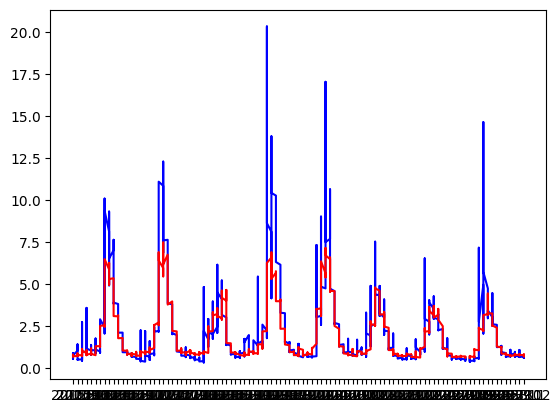

In [17]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
i=0
for train_index, test_index in tscv.split(x):
    
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    print (train_index.min(),train_index.max())
    print (test_index.min(),test_index.max())
    if i>=13:
        lgb = lightgbm.LGBMRegressor( n_estimators=10000, num_leaves=31, learning_rate=0.07, colsample_bytree=0.85,verbose=0)

        lgb.fit(X_train, Y_train,sample_weight=X_train['std_TotalAbBarfVBaran_in'], eval_set=(X_test,Y_test),callbacks=([early_stopping(stopping_rounds=40)]))

        test_predict = lgb.predict(X_test, num_iteration=lgb.best_iteration_)
        train_predict = lgb.predict(X_train, num_iteration=lgb.best_iteration_)

        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))

        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        #plt.show()
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )

print ('mapetest:',np.mean(test_mape))



In [18]:
imp = pd.DataFrame({'Importance':lgb.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(50)
fe.head(50)

,Importance,Feature
1952,48,Total_in_rollingmin_7
554,29,MinDarajehararat_in_rollingmean_180
487,28,TotalAbBarfVBaran_in_rollingstd_180
622,24,MaxDarajehararat_in_rollingmean_180
2028,24,std_TotalAbBarfVBaran_in
625,23,MaxDarajehararat_in_rollingmax_180
2023,20,day_of_year
691,20,Tabkhir_in_rollingstd_180
2021,19,Total_in
1950,17,Total_in_rollingmean_7


In [19]:

df.dropna(inplace=True, axis=1)
df.shape

(8035, 1957)

In [20]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

In [22]:
target=scaled_df['Total_in'].shift(horizon)
y=target
x=scaled_df[:horizon]
#x = scaled_df. drop(columns =[ target ],axis=1)#,'index'

In [23]:
x.shape

(8020, 1957)

In [24]:
y.dropna(inplace=True)

In [25]:
y.shape

(8020,)

rmse: 0.00010679192960155101
r2: 0.8454026347856575
mape: 0.0007576871173156766
rmse: 0.00010770757022470044
r2: 0.8704543185214282
mape: 0.0008488107516511711
rmse: 0.00011776118504890839
r2: 0.732069746227194
mape: 0.0009706699591612805
rmse: 0.00019174998683587255
r2: 0.6255029123468164
mape: 0.0014527492774355994
rmse: 8.79881887537819e-05
r2: 0.9175092584765625
mape: 0.0005643481214106144
rmse: 9.421280205663907e-05
r2: 0.8199446760282464
mape: 0.0005744453416395766
rmse: 7.826189320147025e-05
r2: 0.8607277209379067
mape: 0.000581090080852675
rmse: 8.82033544508613e-05
r2: 0.847203216816976
mape: 0.0005173590140662177
rmsetrain: 0.047525472990632346 rmsetest 0.07337496634677351
r2train: 0.9350766374141348 r2test: 0.817967954803777
mapetest: 260513507686.26663


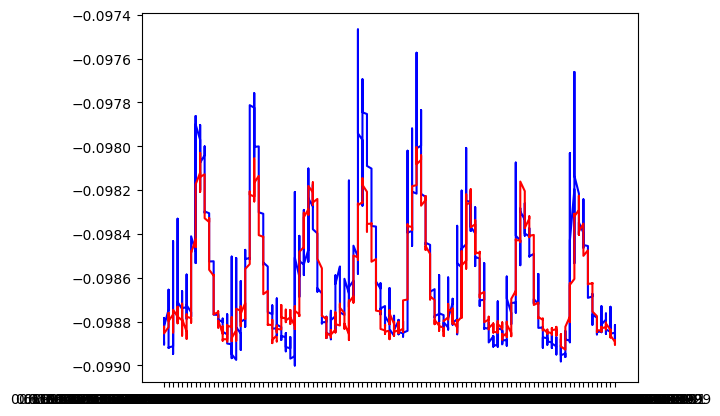

In [26]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        mlp = MLPRegressor(hidden_layer_sizes=(300,100), activation='relu', solver='adam', max_iter=200,learning_rate='constant', early_stopping=True,alpha=  0.05)

        mlp.fit(X_train, Y_train )

        test_predict = mlp.predict(X_test)
        train_predict = mlp.predict(X_train)
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))




rmse: 0.0001619738840274171
r2: 0.6443562234632356
mape: 0.0012804811618536969
rmse: 9.575010263031311e-05
r2: 0.8976214489490927
mape: 0.00073831642151838
rmse: 0.00011865091190448646
r2: 0.7280058387169244
mape: 0.0010191474473005718
rmse: 0.00019181756741264375
r2: 0.6252388894958254
mape: 0.0014328439099319243
rmse: 0.00010072561063587315
r2: 0.8918973675335992
mape: 0.0007201434573385437
rmse: 0.00011115287523690358
r2: 0.749373188791305
mape: 0.0008321214616592112
rmse: 8.953843295876206e-05
r2: 0.8177015558256078
mape: 0.0007259148404960067
rmse: 0.0001078393257279827
r2: 0.771598824586291
mape: 0.0007543282074931405
rmsetrain: 0.03515226921369162 rmsetest 0.0832139938247093
r2train: 0.9647913657159518 r2test: 0.7649807044707981
mapetest: 238563196261.14154


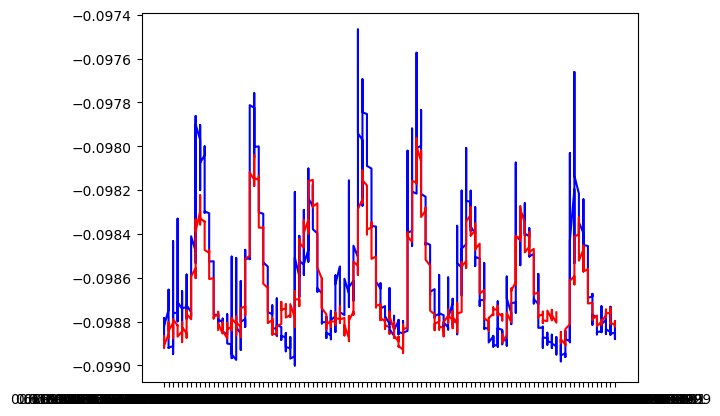

In [27]:
scv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        svr = SVR(kernel='rbf', C=1.0, epsilon=0.001)

        # آموزش مدل
        svr.fit(X_train, Y_train)

        # پیش‌بینی
        test_predict = svr.predict(X_test)
        train_predict = svr.predict(X_train)
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        #plt.show()
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))